# Import required module

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Load data-set

In [95]:

df=pd.read_csv("/home/ranjit/Thesis/CSI_Matlab/CSI_Dataset_final/All_Activity_room.csv")

# df.dropna()
df.head(-10)

,CSI_Value,Amplitude_m,Phase_rad,Activity
0,0.0004883+0.0004883i,1.495711,3.121187,Walking
1,0-0.0004883i,2.589975,1.196861,Walking
2,0.00045778+0.0004883i,4.172037,-1.212026,Walking
3,0.0004883-0.0004883i,2.929800,0.000000,Walking
4,0-3.0519e-05i,2.873450,-2.606634,Walking
...,...,...,...,...
194,0+0.0004883i,1.525342,-0.347052,No_Person
195,0.00045778,1.381774,2.387431,No_Person
196,0.00045778+0.00045778i,1.953200,0.000000,No_Person
197,-3.0519e-05-0.00097659i,1.760585,-2.158794,No_Person


# Visualization of dataset

<AxesSubplot:title={'center':'Total number of sample Vs Activity'}>

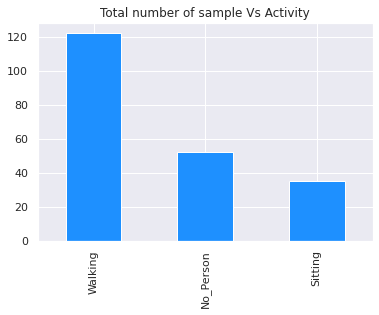

In [96]:
sns.set(color_codes=True)
df['Activity'].value_counts().plot(kind='bar',color="dodgerblue",title='Total number of sample Vs Activity')


In [97]:
def plot_activity(Activity, dataset):
    data = df[df['Activity'] == Activity][['Amplitude_m', 'Phase_rad']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), title=Activity)
    
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

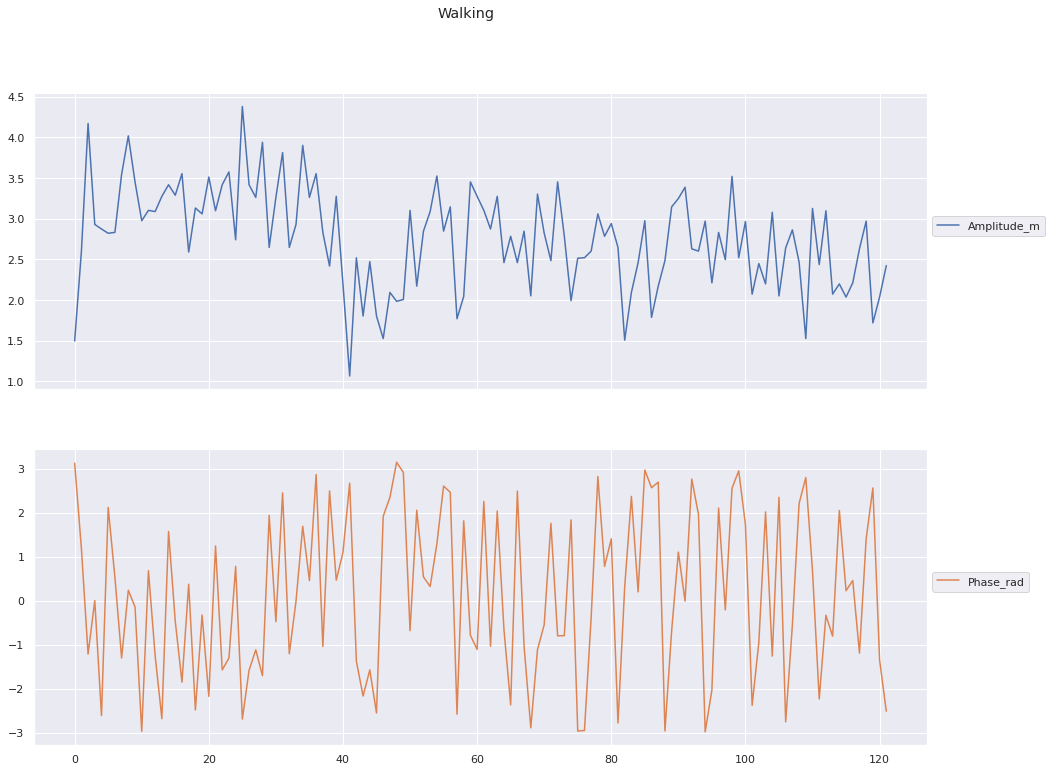

In [98]:
plot_activity("Walking", df)

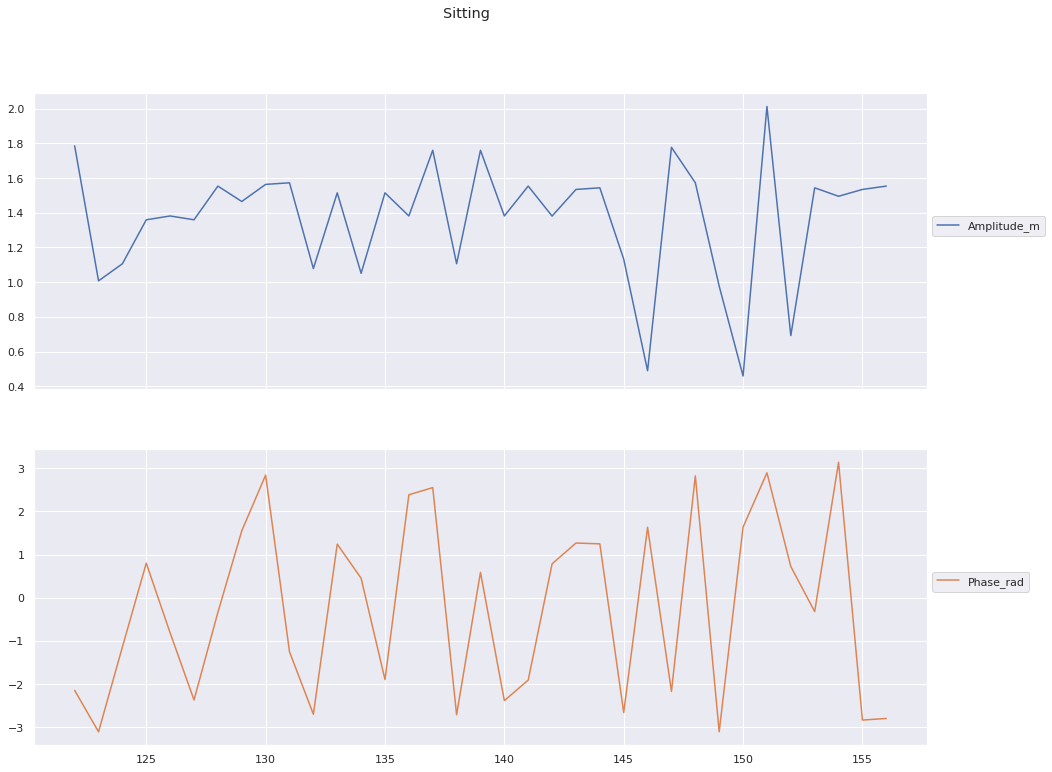

In [99]:
plot_activity("Sitting", df)

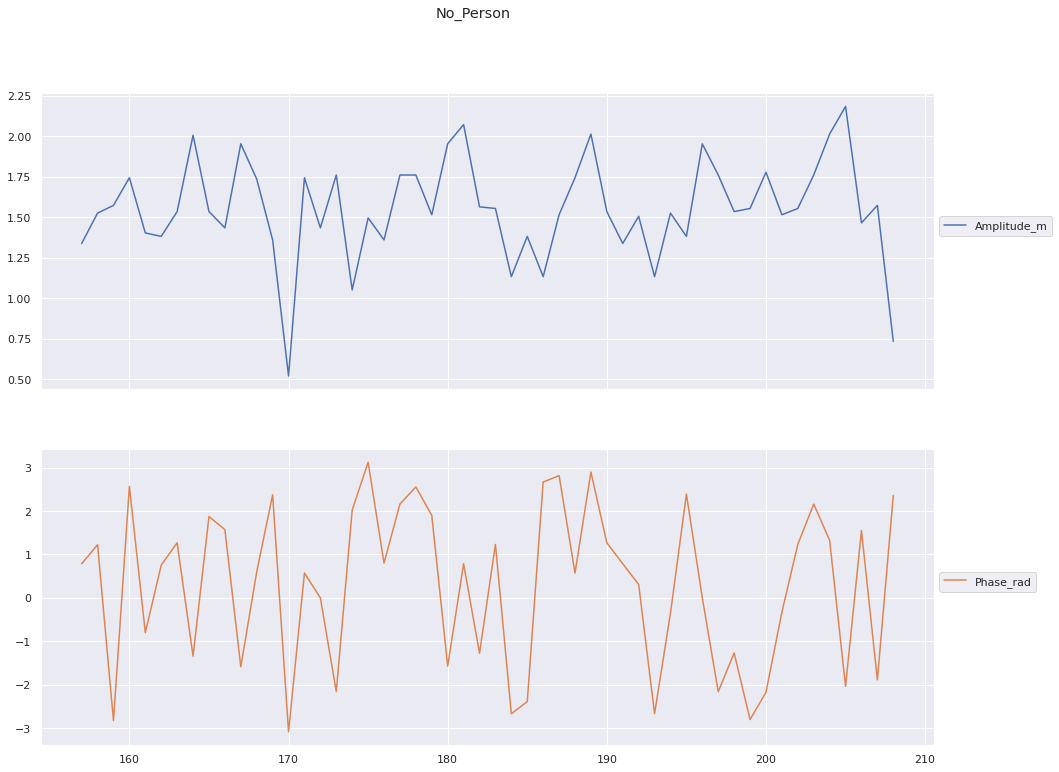

In [100]:
plot_activity("No_Person", df)

# Data Preprocessing

In [104]:
from scipy import stats

num_time_steps = 1
num_features=2
step = 20
segments = []
labels = []
for i in range(0, len(df) - num_time_steps, step):
    amp = df['Amplitude_m'].values[i: i + num_time_steps]
    phs = df['Phase_rad'].values[i: i + num_time_steps]
    label = stats.mode(df['Activity'][i: i + num_time_steps])[0][0]
    segments.append([amp, phs])
    labels.append(label)

In [105]:
np.array(segments).shape

(11, 2, 1)

# Transfering shape of segment

In [106]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, num_time_steps, num_features)


# One-Hot encoding on label (Walking, Sitting, ....)

In [107]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

reshaped_segments.shape

(11, 1, 2)

In [108]:
labels[0]

array([0., 0., 1.], dtype=float32)

# Split the dataset into training (80%) and testing (20%)

In [109]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)



In [110]:
len(X_train)

8

In [111]:
len(X_test)

3

# Building the model -- LSTM
Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [112]:
num_classes = 3
num_hidden_layer = 64

In [113]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf1.Variable(tf.random_normal([num_features, num_hidden_layer])),
        'output': tf1.Variable(tf.random_normal([num_hidden_layer, num_classes]))
    }
    biases = {
        'hidden': tf1.Variable(tf.random_normal([num_hidden_layer], mean=1.0)),
        'output': tf1.Variable(tf.random_normal([num_classes]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, num_features])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, num_time_steps, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_hidden_layer, forget_bias=1.0) for _ in range(2)]
    
    lstm_layers = tf.keras.layers.StackedRNNCells(lstm_layers)


    outputs, _ = tf.compat.v1.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']


# Creating Placeholders:

In [114]:
tf.compat.v1.reset_default_graph() # To clear default graph

X = tf.placeholder(tf.float32, [None, num_time_steps, num_features], name="input") # X values that must be feed using feed dict
Y = tf.placeholder(tf.float32, [None, num_classes]) # Y values that must be feed using feed dict

In [115]:
pred_Y = create_LSTM_model(X)
pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [116]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [117]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

In [118]:
num_epochs=50
BATCH_SIZE = 1024

In [119]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, num_epochs + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={ X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={ X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 5 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test*100}% loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()

print(f'final results: accuracy: {acc_final*100}% loss: {loss_final}')


epoch: 1 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 5 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 10 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 15 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 20 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 25 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 30 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 35 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 40 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 45 test accuracy: 66.66666865348816% loss: 1.6421468257904053
epoch: 50 test accuracy: 66.66666865348816% loss: 1.6421468257904053

final results: accuracy: 66.66666865348816% loss: 1.6421468257904053


In [120]:
import pickle  # implements binary protocols for serializing and de-serializing a Python object structure

history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))


# Evaluation

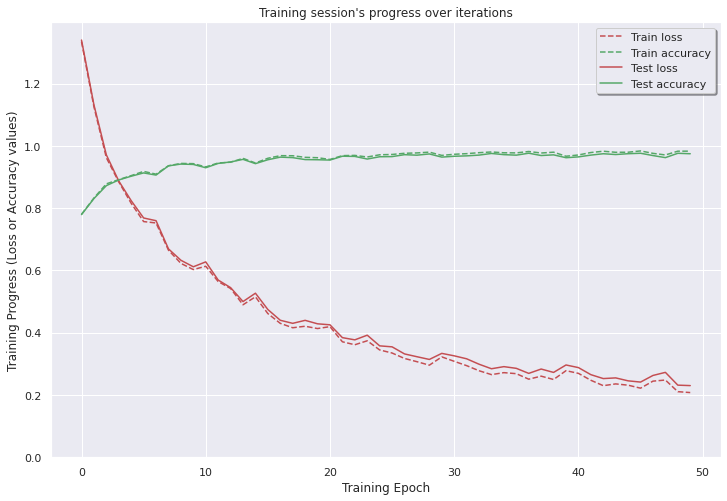

In [122]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()